In [62]:
import pandas as pd

# 基本合并（按列名对齐）
df1 = pd.read_csv("DC_bike/202509-tripdata.csv")
df2 = pd.read_csv("DC_bike/202510-tripdata.csv")
out = pd.concat([df1, df2], ignore_index=True)

out["started_at"] = pd.to_datetime(out["started_at"], errors="coerce")

start_bound = pd.Timestamp("2025-09-01 00:00:00")
end_bound   = pd.Timestamp("2025-10-31 23:59:59")

out = out[(out["started_at"] >= start_bound) & (out["started_at"] <= end_bound)]
out = out.drop_duplicates()
out = out.sort_values(by="started_at", ascending=True)
out = out.reset_index(drop=True)

out.to_csv("DC_bike/20250910-tripdata.csv", index=False)

In [65]:
import pandas as pd

df = pd.read_csv("DC_bike/20250910-tripdata.csv", usecols=[
    "started_at", "ended_at",
    "start_lat", "start_lng",
    "end_lat", "end_lng"
])

print(f"line counts before cleaning: {len(df)}")
df = df.dropna(subset=["started_at", "ended_at", "start_lat", "start_lng", "end_lat", "end_lng"])
print(f"line counts after cleaning: {len(df)}")

df["start_location"] = df.apply(lambda row: (row["start_lng"], row["start_lat"]), axis=1)
df["end_location"] = df.apply(lambda row: (row["end_lng"], row["end_lat"]), axis=1)

df = df.rename(columns={
    "started_at": "start_time",
    "ended_at":   "end_time"
})

out = df[["start_time", "start_location", "end_time", "end_location"]]
out.to_csv("DC_bike/bike_network-0910.csv", index=False)

line counts before cleaning: 1249771
line counts after cleaning: 1249057


In [46]:
import pandas as pd
import geopandas as gpd
import ast
import networkx as nx
from shapely.geometry import Point
from networkx.algorithms.community import louvain_communities

def run_louvain_from_data(trans_data, shp_path, out_path="partition.csv"):
    df = trans_data
    def parse_loc(x):
        if isinstance(x, str):
            return tuple(ast.literal_eval(x))
        return x

    df["start_location"] = df["start_location"].apply(parse_loc)
    df["end_location"] = df["end_location"].apply(parse_loc)

    # 例如：
    gdf_streets = gpd.read_file(shp_path).to_crs(epsg=4326)
    name_col = "NAME"

    gdf_start = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in df["start_location"]],
        crs="EPSG:4326"
    )
    gdf_end = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in df["end_location"]],
        crs="EPSG:4326"
    )

    gdf_start = gpd.sjoin(gdf_start, gdf_streets, how="left", predicate="intersects")
    gdf_end = gpd.sjoin(gdf_end, gdf_streets, how="left", predicate="intersects")

    df["start_anc"] = gdf_start[name_col].values
    df["end_anc"] = gdf_end[name_col].values

    df = df.dropna(subset=["start_anc", "end_anc"])

    G = nx.Graph()
    for _, row in df.iterrows():
        u, v = row["start_anc"], row["end_anc"]
        if u == v:
            continue
        if G.has_edge(u, v):
            G[u][v]["weight"] += 1
        else:
            G.add_edge(u, v, weight=1)

    print(f"Nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

    communities = louvain_communities(G, weight="weight", seed=42, resolution=2.0)
    partition = {node: i for i, comm in enumerate(communities) for node in comm}

    # 写出结果
    partition_df = pd.DataFrame(list(partition.items()), columns=["anc", "community_id"])
    partition_df.to_csv(out_path, index=False, encoding="utf-8-sig")

    print(f"number of {len(communities)} communities, saved to {out_path}")
    return partition_df


trans_data = pd.read_csv("DC_bike/bike_network-10.csv")
partition_df = run_louvain_from_data(
    trans_data=trans_data,
    shp_path="DC_bike/gis/Single_Member_District_from_2023.shp",
    out_path="output/DC_bike/anc_partition-10.csv"
)

Nodes: 281, edges: 16501
number of 17 communities, saved to output/DC_bike/anc_partition-10.csv


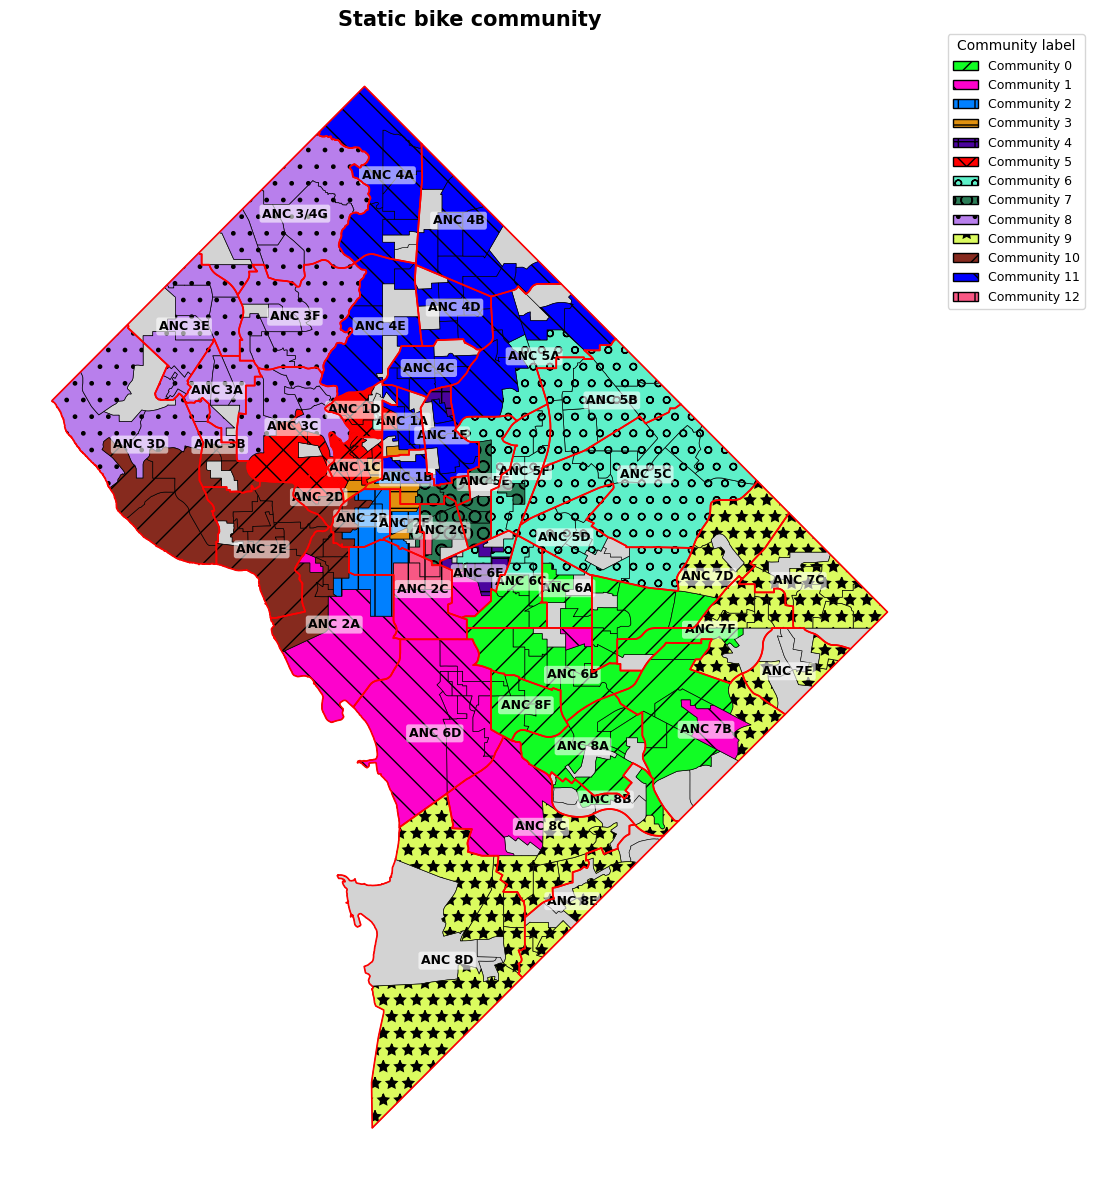

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import distinctipy
import itertools

def plot_community_map(
    streets_shp_path,
    partition_csv_path,
    districts_shp_path,
    out_path=None,
    draw_district_labels=True
):
    # 1) 读数据
    gdf_streets = gpd.read_file(streets_shp_path)
    df_partition = pd.read_csv(partition_csv_path)
    gdf_districts = gpd.read_file(districts_shp_path)

    if gdf_districts.crs != gdf_streets.crs:
        gdf_districts = gdf_districts.to_crs(gdf_streets.crs)


    # 3) 合并 partition
    merged = gdf_streets.merge(df_partition, how="left", left_on="NAME", right_on="anc")

    # 4) 颜色 + 图案
    communities = sorted(merged["community_id"].dropna().unique())
    num_comms = len(communities)
    colors = distinctipy.get_colors(num_comms) if num_comms > 0 else []
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
    hatch_cycle = itertools.cycle(hatches)

    # 5) 绘图
    fig, ax = plt.subplots(figsize=(12, 12))

    # （A）先画未分配街道（灰色底+黑边）
    merged[merged["community_id"].isna()].plot(
        color="lightgray", edgecolor="black", linewidth=0.4, ax=ax, label="未分配"
    )

    legend_patches = []
    for color, cid in zip(colors, communities):
        hatch = next(hatch_cycle)
        subset = merged[merged["community_id"] == cid]
        subset.plot(
            facecolor=color,
            edgecolor="black",
            linewidth=0.5,
            hatch=hatch,
            ax=ax
        )
        legend_patches.append(
            mpatches.Patch(facecolor=color, edgecolor="black", hatch=hatch, label=f"Community {int(cid)}")
        )
    gdf_districts.boundary.plot(ax=ax, edgecolor="red", linewidth=1.2, zorder=10)

    if draw_district_labels and "NAME" in gdf_districts.columns:
        for _, row in gdf_districts.iterrows():
            try:
                pt = row.geometry.representative_point()
                ax.text(
                    pt.x, pt.y,
                    str(row["NAME"]),
                    fontsize=9, fontweight="bold",
                    ha="center", va="center",
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, boxstyle="round,pad=0.2")
                )
            except Exception:
                pass

    if legend_patches:
        ax.legend(
            handles=legend_patches,
            title="Community label",
            loc="upper left",
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0,
            fontsize=9
        )
    ax.set_title("Static bike community", fontsize=15, fontweight="bold")
    ax.axis("off")

    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    return merged

merged_gdf = plot_community_map(
    streets_shp_path="DC_bike/gis/Single_Member_District_from_2023.shp",
    partition_csv_path="output/DC_bike/anc_partition-09.csv",
    districts_shp_path="DC_bike/gis/Advisory_Neighborhood_Commissions_from_2023.shp",
    out_path="plot/DC_bikeplot/community_map-09.png"
)

# links plot on map

In [89]:
# ========= 参数：前百分比 + 兜底条数 + 统一色标 + 自环参数 =========
TOP_PCT   = 0.10     # 前 10% 的边
MIN_EDGES = 30       # 至少画这么多条（若当天边数更少则全画）
LW_MIN, LW_MAX = 1.5, 4.5   # 线宽范围（全局一致缩放）
SELF_ARC_FRAC = 0.015       # 自环半径 = 地图宽高最大边长 * 这个比例（在 EPSG:3857 下）
ARC_ANGLE_SPAN_DEG = 300    # 自环弧长角度（度），300° 看起来像“耳朵”
ARC_OFFSET_DEG     = 30     # 自环起始角度偏移，避免与其它线重叠

import numpy as np
import matplotlib as mpl

# --- 全局统一 colorbar（基于所有天的流量范围） ---
if not flow.empty:
    global_vmin = int(flow["count"].min())
    global_vmax = int(flow["count"].max())
else:
    global_vmin, global_vmax = 0, 1

norm = mpl.colors.Normalize(vmin=global_vmin, vmax=global_vmax)
cmap = mpl.cm.get_cmap("viridis")
sm   = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# --- 为画自环：准备投影到 EPSG:3857 的副本与质心 ---
smd_xy = smd.to_crs(3857).copy()
smd_xy["centroid"] = smd_xy.geometry.centroid
# 注意：SMD_ID_COL 应该是你用于索引质心的字段（比如 "NAME"）
centroids_xy = smd_xy.set_index(SMD_ID_COL)["centroid"].to_dict()

# 逐日绘图（所有出现过的自然日都出图）
days = sorted(df["day"].dropna().unique())

for day in days:
    daily = flow[flow["day"] == day].copy()

    # ---- 基底图均在 EPSG:3857 下绘制（便于用“米”为单位控制自环大小） ----
    fig, ax = plt.subplots(figsize=(12, 12))
    smd_xy.plot(ax=ax, facecolor="#EEEEEE", edgecolor="#FFFFFF", linewidth=0.5)
    smd_xy.set_geometry("centroid").plot(ax=ax, markersize=8, color="black", zorder=5)

    # 计算自环半径（与当天地图显示范围挂钩）
    xmin, ymin, xmax, ymax = smd_xy.total_bounds
    map_size = max(xmax - xmin, ymax - ymin)
    self_r   = map_size * SELF_ARC_FRAC

    if not daily.empty:
        # 只保留当日 Top P% 的边（至少 MIN_EDGES 条）
        daily = daily.sort_values("count", ascending=False)
        k = max(1, int(len(daily) * TOP_PCT))
        k = max(k, min(MIN_EDGES, len(daily)))
        daily_sel = daily.head(k)

        # 拆分普通边与自环
        inter_edges = daily_sel[daily_sel["SMD_start"] != daily_sel["SMD_end"]]
        self_edges  = daily_sel[daily_sel["SMD_start"] == daily_sel["SMD_end"]]

        # ---- 普通边：连质心直线（仍用地理信息，但此处用投影后的质心）----
        for _, row in inter_edges.iterrows():
            s, e, c = row["SMD_start"], row["SMD_end"], row["count"]
            if (s in centroids_xy) and (e in centroids_xy):
                p1, p2 = centroids_xy[s], centroids_xy[e]
                # 线宽按全局范围一致缩放
                if global_vmax > global_vmin:
                    w = LW_MIN + (LW_MAX - LW_MIN) * (c - global_vmin) / (global_vmax - global_vmin)
                else:
                    w = (LW_MIN + LW_MAX) / 2.0
                ax.plot([p1.x, p2.x], [p1.y, p2.y],
                        linewidth=w, color=cmap(norm(c)), alpha=0.5, zorder=4)

        # ---- 自环：围绕质心画圆弧段 ----
        if not self_edges.empty:
            theta0 = np.deg2rad(ARC_OFFSET_DEG)
            theta1 = np.deg2rad(ARC_OFFSET_DEG + ARC_ANGLE_SPAN_DEG)
            thetas = np.linspace(theta0, theta1, 100)

            for _, row in self_edges.iterrows():
                s, c = row["SMD_start"], row["count"]
                if s not in centroids_xy:
                    continue
                pc = centroids_xy[s]
                xs = pc.x + self_r * np.cos(thetas)
                ys = pc.y + self_r * np.sin(thetas)

                if global_vmax > global_vmin:
                    w = LW_MIN + (LW_MAX - LW_MIN) * (c - global_vmin) / (global_vmax - global_vmin)
                else:
                    w = (LW_MIN + LW_MAX) / 2.0

                ax.plot(xs, ys, linewidth=w, color=cmap(norm(c)), alpha=0.5, zorder=6)

        # --- 统一色标（全局 norm） ---
        cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label("Daily Flow (trips)  — global scale")

    ax.set_title(f"Daily SMD Flow (Top {int(TOP_PCT*100)}%) – {day}", fontsize=16)
    ax.set_xlabel("X (m, EPSG:3857)"); ax.set_ylabel("Y (m, EPSG:3857)")
    ax.set_aspect("equal", adjustable="box")
    ax.margins(0.02)

    outpath = os.path.join(OUT_DIR, f"{day}.png")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.close()
    print("已保存：", outpath)

/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_69826/504268206.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis")


已保存： plot/DC_bike/daily_stream/2025-09-01.png
已保存： plot/DC_bike/daily_stream/2025-09-02.png
已保存： plot/DC_bike/daily_stream/2025-09-03.png
已保存： plot/DC_bike/daily_stream/2025-09-04.png
已保存： plot/DC_bike/daily_stream/2025-09-05.png
已保存： plot/DC_bike/daily_stream/2025-09-06.png
已保存： plot/DC_bike/daily_stream/2025-09-07.png
已保存： plot/DC_bike/daily_stream/2025-09-08.png
已保存： plot/DC_bike/daily_stream/2025-09-09.png
已保存： plot/DC_bike/daily_stream/2025-09-10.png
已保存： plot/DC_bike/daily_stream/2025-09-11.png
已保存： plot/DC_bike/daily_stream/2025-09-12.png
已保存： plot/DC_bike/daily_stream/2025-09-13.png
已保存： plot/DC_bike/daily_stream/2025-09-14.png
已保存： plot/DC_bike/daily_stream/2025-09-15.png
已保存： plot/DC_bike/daily_stream/2025-09-16.png
已保存： plot/DC_bike/daily_stream/2025-09-17.png
已保存： plot/DC_bike/daily_stream/2025-09-18.png
已保存： plot/DC_bike/daily_stream/2025-09-19.png
已保存： plot/DC_bike/daily_stream/2025-09-20.png
已保存： plot/DC_bike/daily_stream/2025-09-21.png
已保存： plot/DC_bike/daily_stream/202

In [84]:
df

,start_time,start_location,end_time,end_location,day,SMD_start,SMD_end
0,2025-09-01 00:00:05.104,"(-77.02200293540955, 38.91613684808331)",2025-09-01 00:12:40.259,"(-77.048728, 38.909394)",2025-09-01,SMD 1B02,SMD 2B02
1,2025-09-01 00:00:15.725,"(-77.03188, 38.910674)",2025-09-01 00:28:25.118,"(-76.99, 38.89)",2025-09-01,SMD 2F03,SMD 6A04
2,2025-09-01 00:00:21.996,"(-77.050335646, 38.905355573)",2025-09-01 00:13:55.726,"(-77.04, 38.93)",2025-09-01,SMD 2A06,SMD 1D05
3,2025-09-01 00:00:32.531,"(-77.0315, 38.9308)",2025-09-01 00:04:10.747,"(-77.040787, 38.924088)",2025-09-01,SMD 1A02,SMD 1C05
4,2025-09-01 00:00:37.516,"(-77.00320065021515, 38.905690963097)",2025-09-01 00:08:54.449,"(-77.0078, 38.915)",2025-09-01,SMD 6C07,SMD 5F07
...,...,...,...,...,...,...,...
1249052,2025-10-31 23:55:20.070,"(-77.023924, 38.898097)",2025-10-31 23:59:22.860,"(-77.0284, 38.903819)",2025-10-31,SMD 2C01,SMD 2C04
1249053,2025-10-31 23:56:03.899,"(-77.0, 38.92)",2025-10-31 23:59:48.495,"(-76.978924, 38.927095)",2025-10-31,SMD 5F03,SMD 5C07
1249054,2025-10-31 23:56:31.277,"(-77.00416892766953, 38.8762192324865)",2025-10-31 23:57:38.679,"(-77.00575411319733, 38.875022735559995)",2025-10-31,SMD 8F02,SMD 8F02
1249055,2025-10-31 23:57:01.340,"(-77.04252451658249, 38.9228491613136)",2025-10-31 23:57:03.659,"(-77.04, 38.92)",2025-10-31,SMD 1C05,SMD 1C07


## Daily nodes and links

In [66]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


CSV_PATH = "DC_bike/bike_network-0910.csv"
SMD_SHP_PATH = "DC_bike/gis/Single_Member_District_from_2023.shp"
OUT_PNG = "per_day_dual_axis.png"
# ===================================
def parse_loc(x):
    if isinstance(x, str):
        return tuple(ast.literal_eval(x))
    return x


def map_points_to_smd(df_points, lon_col, lat_col, smd_path):
    gdf_points = gpd.GeoDataFrame(
        df_points[[lon_col, lat_col]].copy(),
        geometry=[Point(lon, lat) for lon, lat in zip(df_points[lon_col], df_points[lat_col])],
        crs="EPSG:4326",
    )
    smd = gpd.read_file(smd_path)
    if smd.crs is None:
        smd = smd.set_crs("EPSG:4326")
    if smd.crs != gdf_points.crs:
        gdf_points = gdf_points.to_crs(smd.crs)

    joined = gpd.sjoin(gdf_points, smd, how="left", predicate="within")
    name_col = "NAME"
    return joined[name_col].astype(object)

def load_and_prepare(csv_path, smd_shp_path=None):
    df = pd.read_csv(csv_path)

    # 时间
    df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
    df["end_time"] = pd.to_datetime(df["end_time"], errors="coerce")

    # 坐标
    df["start_location"] = df["start_location"].apply(parse_loc)
    df["end_location"] = df["end_location"].apply(parse_loc)

    for col_pair, prefix in [("start_location", "start"), ("end_location", "end")]:
        df[f"{prefix}_lon"] = df[col_pair].apply(lambda t: t[0] if isinstance(t, tuple) and len(t) == 2 else np.nan)
        df[f"{prefix}_lat"] = df[col_pair].apply(lambda t: t[1] if isinstance(t, tuple) and len(t) == 2 else np.nan)

    # 映射 SMD
    if smd_shp_path:
        df["start_SMD"] = map_points_to_smd(df, "start_lon", "start_lat", smd_shp_path)
        df["end_SMD"]   = map_points_to_smd(df, "end_lon", "end_lat", smd_shp_path)
    else:
        df["start_SMD"] = np.nan
        df["end_SMD"]   = np.nan

    # 自然日（按 start_time 所在日期）
    df["day"] = df["start_time"].dt.date

    valid = df["start_SMD"].notna() & df["end_SMD"].notna()
    df = df[valid].copy()

    return df


def compute_daily_metrics(df, directed=False):
    # 生成边键
    if directed:
        # 有向：保留先后（start_SMD -> end_SMD）
        df["edge_key"] = list(zip(df["start_SMD"].astype(str), df["end_SMD"].astype(str)))
    else:
        # 无向：按字典序排序成无向对
        df["edge_key"] = df.apply(
            lambda r: tuple(sorted((str(r["start_SMD"]), str(r["end_SMD"])))),
            axis=1
        )

    # 每日边计数（边权重 = 通勤次数）
    edges_daily = (
        df.groupby(["day", "edge_key"])
          .size()
          .reset_index(name="count")
    )
    edges_split = edges_daily["edge_key"].apply(pd.Series).rename(columns={0: "SMD_U", 1: "SMD_V"})
    edges_daily = pd.concat([edges_daily.drop(columns=["edge_key"]), edges_split], axis=1)

    # 每日节点集合与权重总和
    def _daily_nodes_and_sum(g):
        # 节点集合
        nodes = pd.unique(pd.concat([g["SMD_U"], g["SMD_V"]], ignore_index=True))
        return pd.Series({
            "node_count": len(nodes),
            "edge_weight_sum": g["count"].sum()
        })

    metrics = (
        edges_daily.groupby("day")
                   .apply(_daily_nodes_and_sum)
                   .reset_index()
    )
    # 排序 & day 转时间戳，方便画图
    metrics["day"] = pd.to_datetime(metrics["day"])
    metrics = metrics.sort_values("day", ignore_index=True)
    return edges_daily, metrics

df = load_and_prepare(CSV_PATH, SMD_SHP_PATH)
edges_daily, metrics = compute_daily_metrics(df, directed=False)

/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_69826/1760843492.py:100: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_daily_nodes_and_sum)


In [80]:
df

,start_time,start_location,end_time,end_location,start_point,end_point,start_lon,start_lat,end_lon,end_lat,SMD_start,SMD_end,day
0,2025-09-01 00:00:05.104,"(-77.02200293540955, 38.91613684808331)",2025-09-01 00:12:40.259,"(-77.048728, 38.909394)","(-77.02200293540955, 38.91613684808331)","(-77.048728, 38.909394)",NaN,NaN,NaN,NaN,NaN,NaN,2025-09-01
1,2025-09-01 00:00:15.725,"(-77.03188, 38.910674)",2025-09-01 00:28:25.118,"(-76.99, 38.89)","(-77.03188, 38.910674)","(-76.99, 38.89)",NaN,NaN,NaN,NaN,NaN,NaN,2025-09-01
2,2025-09-01 00:00:21.996,"(-77.050335646, 38.905355573)",2025-09-01 00:13:55.726,"(-77.04, 38.93)","(-77.050335646, 38.905355573)","(-77.04, 38.93)",NaN,NaN,NaN,NaN,NaN,NaN,2025-09-01
3,2025-09-01 00:00:32.531,"(-77.0315, 38.9308)",2025-09-01 00:04:10.747,"(-77.040787, 38.924088)","(-77.0315, 38.9308)","(-77.040787, 38.924088)",NaN,NaN,NaN,NaN,NaN,NaN,2025-09-01
4,2025-09-01 00:00:37.516,"(-77.00320065021515, 38.905690963097)",2025-09-01 00:08:54.449,"(-77.0078, 38.915)","(-77.00320065021515, 38.905690963097)","(-77.0078, 38.915)",NaN,NaN,NaN,NaN,NaN,NaN,2025-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249052,2025-10-31 23:55:20.070,"(-77.023924, 38.898097)",2025-10-31 23:59:22.860,"(-77.0284, 38.903819)","(-77.023924, 38.898097)","(-77.0284, 38.903819)",NaN,NaN,NaN,NaN,NaN,NaN,2025-10-31
1249053,2025-10-31 23:56:03.899,"(-77.0, 38.92)",2025-10-31 23:59:48.495,"(-76.978924, 38.927095)","(-77.0, 38.92)","(-76.978924, 38.927095)",NaN,NaN,NaN,NaN,NaN,NaN,2025-10-31
1249054,2025-10-31 23:56:31.277,"(-77.00416892766953, 38.8762192324865)",2025-10-31 23:57:38.679,"(-77.00575411319733, 38.875022735559995)","(-77.00416892766953, 38.8762192324865)","(-77.00575411319733, 38.875022735559995)",NaN,NaN,NaN,NaN,NaN,NaN,2025-10-31
1249055,2025-10-31 23:57:01.340,"(-77.04252451658249, 38.9228491613136)",2025-10-31 23:57:03.659,"(-77.04, 38.92)","(-77.04252451658249, 38.9228491613136)","(-77.04, 38.92)",NaN,NaN,NaN,NaN,NaN,NaN,2025-10-31


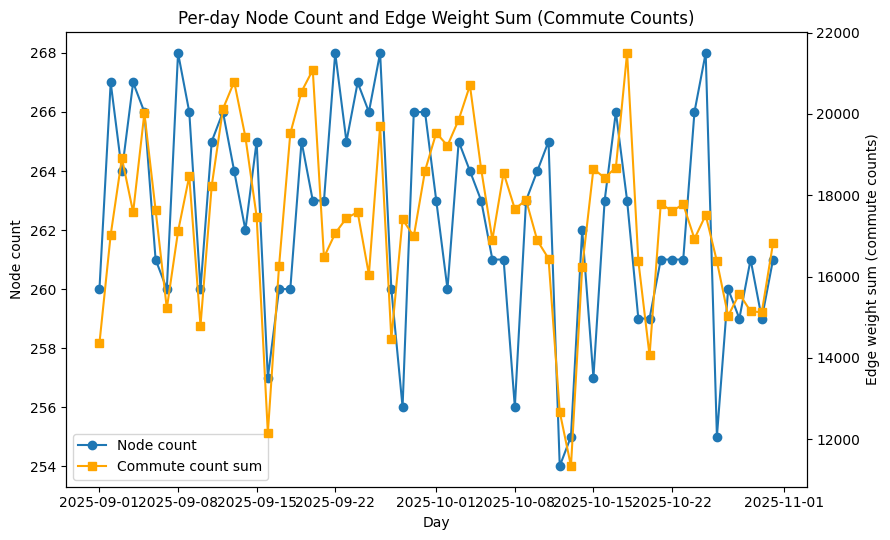

In [67]:
def plot_dual_axis(agg_df, out_png=OUT_PNG, title="Per-day Node Count and Edge Weight Sum (Commute Counts)"):
    plt.figure(figsize=(9, 5.5))
    ax1 = plt.gca()
    l1, = ax1.plot(agg_df["day"], agg_df["node_count"], marker="o", label="Node count")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("Node count")
    ax2 = ax1.twinx()
    l2, = ax2.plot(agg_df["day"], agg_df["edge_weight_sum"], marker="s", color="orange", label="Commute count sum")
    ax2.set_ylabel("Edge weight sum (commute counts)")
    lines, labels = [l1, l2], [l1.get_label(), l2.get_label()]
    ax1.legend(lines, labels, loc="best")
    plt.title(title)
    plt.tight_layout()
    plt.savefig("plot/DC_bikeplot/daily-node-edge.png", dpi=180)

plot_dual_axis(metrics)

In [40]:
import geopandas as gpd


file_path = "DC_bike/gis/Single_Member_District_from_2023.shp"
gdf = gpd.read_file(file_path)
gdf.head(2)

,SMD_ID,ANC_ID,WEB_URL,NAME,CHAIR,REP_NAME,LAST_NAME,FIRST_NAME,ADDRESS,MIDDLE_NAM,...,PHONE,EMAIL,SE_ANNO_CA,GLOBALID,CREATED,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,1C08,1C,https://anc1c.org/,SMD 1C08,PETER WOOD,DAVID FUCILLO,FUCILLO,DAVID,2440 16TH ST NE,None,...,None,1C08@anc.dc.gov,None,{71F7E6FE-D54A-4AB5-A1C3-35D6545D00E4},2022-12-21,2025-04-25,2906,0,0,"POLYGON ((-8575662.858 4710610.78, -8575662.76..."
1,1C07,1C,https://anc1c.org/,SMD 1C07,PETER WOOD,JEAN EVANS,FALESCHINI,JAKE,2205 CHAMPLAIN STREET NW\n,None,...,None,1C07@anc.dc.gov,None,{B49A608D-FFA3-4459-836F-9F7F056773FB},2022-12-21,2025-01-08,2907,0,0,"POLYGON ((-8575962.446 4710924.908, -8575959.0..."


In [4]:
import geopandas as gpd


gdf = gpd.read_file("DC_bike/gis/Advisory_Neighborhood_Commissions_from_2023.shp")
gdf

,ANC_ID,NAME,WEB_URL,GIS_ID,SE_ANNO_CA,GLOBALID,CREATED,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,1A,ANC 1A,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_321,None,{88F50930-8B79-42D6-BF7A-C31F5A413033},2022-12-21,2022-12-21,321,0,0,"POLYGON ((-8575663.221 4710684.843, -8575663.1..."
1,1B,ANC 1B,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_322,None,{E35D70DC-39D5-4FED-9223-20E919625E4D},2022-12-21,2022-12-21,322,0,0,"POLYGON ((-8573606.021 4709417.436, -8573616.9..."
2,1C,ANC 1C,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_323,None,{03D85E81-71B0-49F3-A12A-DACCBDDB39DA},2022-12-21,2022-12-21,323,0,0,"POLYGON ((-8576740.225 4709415.623, -8576742.7..."
3,1D,ANC 1D,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_324,None,{03F8CF93-E16E-4508-81B6-F935AB200196},2022-12-21,2022-12-21,324,0,0,"POLYGON ((-8575783.338 4711213.775, -8575785.1..."
4,1E,ANC 1E,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_325,None,{1C89F951-10EE-4B79-A4FA-67BFED95FCF5},2022-12-21,2022-12-21,325,0,0,"POLYGON ((-8574038.587 4709899.279, -8574054.5..."
5,2A,ANC 2A,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_326,None,{6B04B45A-C9A9-44CE-AF80-B79F4F349D77},2022-12-21,2022-12-21,326,0,0,"POLYGON ((-8575347.281 4706227.201, -8575348.0..."
6,2B,ANC 2B,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_327,None,{66AB8B2C-019C-4DD3-9FE3-A4471C5BB73E},2022-12-21,2022-12-21,327,0,0,"POLYGON ((-8576793.658 4708163.251, -8576793.5..."
7,2C,ANC 2C,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_328,None,{CBDBE6C2-4056-4E1D-88C3-5D5CC6CE4B5E},2022-12-21,2022-12-21,328,0,0,"POLYGON ((-8573290.007 4705689.299, -8573290.0..."
8,2D,ANC 2D,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_329,None,{ECAFA288-0C8D-4881-9A0D-BCA9A55FD208},2022-12-21,2022-12-21,329,0,0,"POLYGON ((-8578066.297 4709874.677, -8578079.3..."
9,2E,ANC 2E,http://anc.dc.gov/page/advisory-neighborhood-c...,ANCPly_330,None,{57B002D6-8E45-490A-9804-591BB79A60A0},2022-12-21,2022-12-21,330,0,0,"POLYGON ((-8578698.383 4706178.543, -8578724.3..."
